<a href="https://colab.research.google.com/github/solobala/STPY36/blob/main/STPY36_DZ8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Домашнее задание к лекции «Кейс-стади»

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile  
import re
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#  Статистика
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import scipy as sp
from scipy import stats as st
from scipy.stats import t
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
from pylab import rcParams
rcParams['figure.figsize'] = 11,7 #увеличим дефолтный размер графиков

## Загрузка датасетов

In [ ]:
!wget 'https://github.com/solobala/STPY36/raw/master/datasets.zip' # Пришлось предварительно загрузить себе не комп, сархивировать, положить архив к себе на гитхаб

--2022-11-06 18:28:15--  https://github.com/solobala/STPY36/raw/master/datasets.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/solobala/STPY36/master/datasets.zip [following]
--2022-11-06 18:28:15--  https://raw.githubusercontent.com/solobala/STPY36/master/datasets.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 701189 (685K) [application/zip]
Saving to: ‘datasets.zip’

datasets.zip        100%[===================>] 684.75K  --.-KB/s    in 0.04s   

2022-11-06 18:28:15 (15.5 MB/s) - ‘datasets.zip’ saved [701189/701189]



In [ ]:
with ZipFile('/content/datasets.zip', 'r') as zip_file:
  zip_file.extractall() 

In [ ]:
data=pd.read_csv('/content/vgsales.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [ ]:
data['Critic_Score'] = data['Critic_Score'].astype('float64')
data['Critic_Count'] = data['Critic_Count'].astype('Int64')

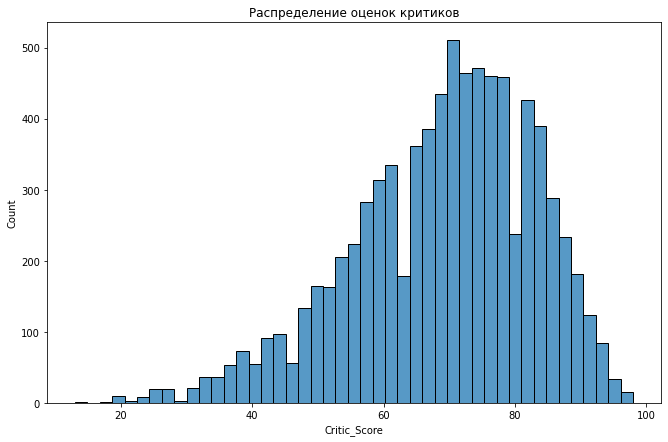

In [ ]:
sns.histplot(data['Critic_Score'])
plt.title('Распределение оценок критиков')
plt.show()

## Вспомогательные функции

In [ ]:
def fisher_test(data):
    print('Нулевая гипотеза:', '='.join(data))
    print('Альтернативная гипотеза:', f'!({"=".join(data)})')
    grand_mean =data.values[~np. isnan (data)].flatten().mean() 
    sst = sum((val - grand_mean)**2 for val in data.values[~np. isnan (data)].flatten())
    ssb = sum(data[data[group].notna()][group].size * (group_mean - grand_mean) ** 2 for group, group_mean in data.mean().items())
    ssw = sum(sum((x - group_mean)**2 for x in data[data[group].notna()][group]) for group, group_mean in data.mean().items())
    groups = data.shape[1]
    dfb = groups - 1
    dfw =len(data.values[~np. isnan (data)].flatten()) - groups
    mssb = ssb/dfb
    mssw = ssw/dfw
    f_value = mssb/mssw
    p = st.f.sf(f_value, dfb, dfw) #sf - Survival function - что это такое? Это оценка вероятности наступления события
    print('Результат:')
    if p < 0.05:
        print('отклоняем нулевую гипотезу')
    else:
        print('Не отклоняем нулевую гипотезу')
    print(f"p_value = {p},  f-значение = {f_value}")

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def my_result(cnf_matrix):
  TN = cnf_matrix[0][0] # True Negative 
  FP = cnf_matrix[0][1] # False Positive Errors - ошибки 1 рода
  FN = cnf_matrix[1][0] # False Negative Errors - ошибки 2 рода
  TP = cnf_matrix[1][1] # True Positive 
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  print('Модель логистической регрессии - результат работы: ')
  print(f' Ошибки 1 рода (FP): {FP}, ошибки 2 рода (FN): {FN} ')
  print(f'точность модели (precision): {precision}, полнота (recall): {recall}')  

# Задание 1
Вернемся к набору данных о видеоиграх.

Ответьте на следующие вопросы:

Как критики относятся к спортивным играм?
Критикам нравятся больше игры на PC или на PS4?
Критикам больше нравятся стрелялки или стратегии?
Для каждого вопроса:

сформулируйте нулевую и альтернативную гипотезы;
выберите пороговый уровень статистической значимости;
опишите полученные результаты статистического теста.

### Как критики относятся к спортивным играм?

Посмотрим на боксплоты оценок критиками видеоигр по жанрам

In [ ]:
df = []
for genre in data.Genre.unique():
    df.append(
        go.Box(y=data[data.Genre==genre].Critic_Score, 
               name=genre)
    )
iplot(df, show_link = False)

Рассматриваем наш датасет как генеральную совокупность. Выберем из него спортивные игры

In [ ]:
all_games = data.loc[:,['Critic_Score', 'Critic_Count']] # все игры
all_games.dropna(inplace = True)

In [ ]:
sports = data.loc[data['Genre'] =='Sports',['Critic_Score', 'Critic_Count']] # спортивные игры
sports.dropna(inplace = True)

In [ ]:
df = []
df.append(go.Box(y=all_games.Critic_Score, name = 'all games'))
df.append(go.Box(y=sports.Critic_Score,    name='sport games'))
iplot(df, show_link = False)

Рассчитаем среднее и стандартные отклонения по группам

In [ ]:
all_games_mean = all_games.Critic_Score.mean()
all_games_std = all_games.Critic_Score.std()
sports_mean = sports.Critic_Score.mean()
sports_std = sports.Critic_Score.std()
print(f'Средняя оценка игр критиками независимо от жанра: {all_games_mean}, средняя оценка спортивных игр: {sports_mean}')
print(f'Стандартное отклонение средней оценки игр критиками независимо от жанра: {all_games_std}, стандартное отклонение средней оценки спортивных игр: {sports_std}')

Средняя оценка игр критиками независимо от жанра: 68.96767850559173, средняя оценка спортивных игр: 71.96817420435511
Стандартное отклонение средней оценки игр критиками независимо от жанра: 13.938164552843212, стандартное отклонение средней оценки спортивных игр: 13.878432513646741


#### H0: Оценка критиками спортивных огр = средней оценке игр независимо от  жанра
#### H1: Критики выше оценивают спортивные игры, чем игры других жанров

In [ ]:
stat, p = st.ttest_1samp(a = sports['Critic_Score'], popmean = all_games_mean,  alternative = 'greater')
print('Статистика = %.5f, p  =%.5f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу - оценка игр независимо от жанра = оценке спортивных видеоигр')
else:
    print('Отклоняем нулевую гипотезу И принимаем альтернативную - оценка спортивных видеоигр >  оценки игр независимо от жанра')

Статистика = 7.47059, p  =0.00000
Отклоняем нулевую гипотезу И принимаем альтернативную - оценка спортивных видеоигр >  оценки игр независимо от жанра


### Критикам нравятся больше игры на PC или на PS4?

Расссмотрим отдельно игры на PC и игры на PS4

In [ ]:
games_pc = data.loc[data['Platform'] =='PC',['Critic_Score', 'Critic_Count']]
games_pc.dropna(inplace = True)

In [ ]:
games_ps4 = data.loc[data['Platform'] =='PS4',['Critic_Score', 'Critic_Count']]
games_ps4.dropna(inplace = True)

In [ ]:
df = []
for platform in ['PC', 'PS4']:
    df.append(
        go.Box(y=data[data.Platform==platform].Critic_Score, 
               name=platform)
    )
iplot(df, show_link = False)

Рассчитаем среднее и стандартные отклонения по группам

In [ ]:
games_pc_mean = games_pc.Critic_Score.mean()
games_pc_std = games_pc.Critic_Score.std()
games_ps4_mean = games_ps4.Critic_Score.mean()
games_ps4_std = games_ps4.Critic_Score.std()
print(f'Средняя оценка критиками игр на PC: {games_pc_mean}, средняя оценка игр на PS4: {games_ps4_mean}')
print(f'Стандартное отклонение средней оценки критиками игр на PC: {games_pc_std}, стандартное отклонение средней оценки игр на PS4: {games_ps4_std}')

Средняя оценка критиками игр на PC: 75.92867132867133, средняя оценка игр на PS4: 72.09126984126983
Стандартное отклонение средней оценки критиками игр на PC: 11.170775336632445, стандартное отклонение средней оценки игр на PS4: 12.485992277826996


#### H0: Средние оценка для игр на PC и игр на PS4 равны
#### H1:  Критики выше оценивают игры на PC, чем игры на PS4

  Используем st.f_oneway для проверки нулевой гипотезы о равенстве дисперсий

In [ ]:
fvalue, pvalue = st.f_oneway(games_pc['Critic_Score'],games_ps4['Critic_Score'])
print('Статистика=%.3f, p=%.6f' % (fvalue, pvalue))
if pvalue > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=20.649, p=0.000006
Отклоняем нулевую гипотезу, средние, вероятно, различаются


In [ ]:
stat, p = st.ttest_ind(games_pc['Critic_Score'],games_ps4['Critic_Score'], equal_var = False, alternative = 'greater')
print('Статистика=%.5f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу - оценка игр на PC = оценке игр на PS4')
else:
    print('Отклоняем нулевую гипотезу И принимаем альтернативную - оценка игр на PC > оценки игр на PS4')

Статистика=4.30876, p=0.00001
Отклоняем нулевую гипотезу И принимаем альтернативную - оценка игр на PC > оценки игр на PS4


### Критикам больше нравятся стрелялки или стратегии? 

In [ ]:
shooter = data.loc[data['Genre'] =='Shooter',['Critic_Score', 'Critic_Count']]
shooter.dropna(inplace = True)

In [ ]:
strategy = data.loc[data['Genre'] =='Strategy',['Critic_Score', 'Critic_Count']]
strategy.dropna(inplace = True)

In [ ]:
df = []
for genre in ['Shooter', 'Strategy']:
    df.append(
        go.Box(y=data[data.Genre==genre].Critic_Score, 
               name=genre)
    )
iplot(df, show_link = False)

Рассчитаем среднее и стандартные отклонения по группам

In [ ]:
shooter_mean = shooter.Critic_Score.mean()
shooter_std = shooter.Critic_Score.std()
strategy_mean = strategy.Critic_Score.mean()
strategy_std =strategy.Critic_Score.std()
print(f'Средняя оценка критиками игр Shooter: {shooter_mean}, средняя оценка игр Strategy: {strategy_mean}')
print(f'Стандартное отклонение средней оценки критиками игр Shooter: {shooter_std}, стандартное отклонение средней оценки игр Strategy: {strategy_std}')

Средняя оценка критиками игр Shooter: 70.18114406779661, средняя оценка игр Strategy: 72.08609271523179
Стандартное отклонение средней оценки критиками игр Shooter: 14.552571329694269, стандартное отклонение средней оценки игр Strategy: 11.828475354020807


H0: Средние оценка для стрелялок и стратегий равны
H1: Критики выше оценивают стратегии, чем стрелялки

  Используем st.f_oneway для проверки нулевой гипотезы о равенстве дисперсий

In [ ]:
fvalue, pvalue = st.f_oneway(shooter['Critic_Score'],strategy['Critic_Score'])
print('Статистика=%.3f, p=%.6f' % (fvalue, pvalue))
if pvalue > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=4.271, p=0.038969
Отклоняем нулевую гипотезу, средние, вероятно, различаются


In [ ]:
stat, p = st.ttest_ind(strategy['Critic_Score'], shooter['Critic_Score'], equal_var = False, alternative = 'greater')
print('Статистика=%.5f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу - оценка стратегий = оценке стрелялок')
else:
    print('Отклоняем нулевую гипотезу И принимаем альтернативную - оценка стратегий > оценки стрелялок')

Статистика=2.29724, p=0.01097
Отклоняем нулевую гипотезу И принимаем альтернативную - оценка стратегий > оценки стрелялок


# Задание 2

Реализуйте базовую модель логистической регрессии для классификации текстовых сообщений (используемые данные здесь) по признаку спама. Для этого:

1.   Привидите весь текст к нижнему регистру;
2.   Удалите мусорные символы;
3.   Удалите стоп-слова;
4.   Привидите все слова к нормальной форме;
5.   Преобразуйте все сообщения в вектора TF-IDF. 

Вам поможет следующий код:


```
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df.Message)
names = tfidf.get_feature_names()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)

```



Можете поэкспериментировать с параметрами TfidfVectorizer;

6.   Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите random_state=42. Используйте train_test_split;
7.   Постройте модель логистической регрессии, укажите random_state=42, оцените ее точность на тестовых данных;
8.   Опишите результаты при помощи confusion_matrix;
9.   Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).

In [ ]:
df=pd.read_csv('/content/spam.csv') #Читаем файл в датафрейм
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.Category.unique() # проверим, сколько классов предлагается для классификации - Всего 2 - ham и spam

array(['ham', 'spam'], dtype=object)

Оценим соотношение классов

In [ ]:
print('Кол-во сообщений - спам: ', len(df[df.Category =='spam']), 'Кол-во полезных сообщений: ', len(df[df.Category =='ham']))

Кол-во сообщений - спам:  747 Кол-во полезных сообщений:  4825


Классы несбалансированы, для оценки качества модели понадобятся precision и recall

## Вариант 1. Предобработка датасета

In [ ]:
data = df.copy()

In [ ]:
data['Message_'] = data['Message'].apply(lambda word: word.lower()) # Приведем к нижнему регистру  Все слова в Message и запишем результат в Message_

In [ ]:
data['Message_'] = data['Message_'].apply(lambda word: re.sub('[\W_]+', ' ', word)) # Уберем спец. символы

In [ ]:
data['messages_splitted']=data['Message_'].apply(lambda word: word.split()) # разобьем на слова

In [ ]:
nltk.download('stopwords') # Уберем стоп-слова
stopwords_set = set(stopwords.words('english'))
data['without_sw'] = [[word  for word in row if word not in stopwords_set ] for row in data['messages_splitted']] 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Произведем лемматизацию
nltk.download('omw-1.4')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
data['lemmatized_text'] = [[wordnet_lemmatizer.lemmatize(word) for word in text] for text in data['without_sw'] ]

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data['message__']=[' '.join(x) for x in data['lemmatized_text']] # Получим опять текст сообщения, но без спец символов, стоп слов и приведенное к нижнему регистру

In [ ]:
data['Category_'] =[0 if x =='spam' else 1 for x in data.Category] # Добавим еще оин столбец Category_, в котором 1 - это ham,0 - spam

In [ ]:
data.loc[:,['Category','Category_']]

,Category,Category_
0,ham,1
1,ham,1
2,spam,0
3,ham,1
4,ham,1
...,...,...
5567,spam,0
5568,ham,1
5569,ham,1
5570,ham,1


In [ ]:
data_class = data.Category_

In [ ]:
#Преобразуем все сообщения в вектора TF-IDF. 
tfidf = TfidfVectorizer() 
tfidf_matrix = tfidf.fit_transform(data['message__'])
names = tfidf.get_feature_names_out() 
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, data_class, test_size=0.3, random_state=42) # разбиваем датаасет на обучающую и тестовую выборки
lr = LogisticRegression()

In [ ]:
lr.fit(X_train, y_train) # обучаем модель
y_pred = lr.predict(X_test) # прогнозируем класс


In [ ]:
# смотрим разницу факта и прогноза
result = pd.DataFrame([y_test, y_pred]).T

In [ ]:
result

,Category_,Unnamed 0
3245,1.0,NaN
944,1.0,1.0
1044,1.0,1.0
2484,1.0,NaN
812,1.0,1.0
...,...,...
2505,1.0,NaN
2525,0.0,NaN
4975,1.0,NaN
650,0.0,1.0


In [ ]:
result.rename(columns ={0: 'Category_test', 1: 'Category_predict'}, inplace = True)

In [ ]:
result['Category_test']= ['ham' if x == 1 else 'spam' for x in result['Category_test']]

In [ ]:
result['Category_predict']= ['ham' if x == 1 else 'spam' for x in result['Category_predict']]

In [ ]:
model_errors =result[result['Category_test']!=result['Category_predict']]
model_errors

,Category_test,Category_predict
17,ham,spam
40,spam,ham
47,spam,ham
74,spam,ham
84,spam,ham
...,...,...
1525,spam,ham
1567,spam,ham
1569,spam,ham
1576,ham,spam


In [ ]:
data.iloc[40]

In [ ]:
bad_index = list(result[result['Category_test']!=result['Category_predict']].index) # 'это индексы неверно расклассифицированных сообщений

In [ ]:
print('Количество сообщений с неправильно определенными классами: ', len(result[result['Category_test']!=result['Category_predict']]))

Количество сообщений с неправильно определенными классами:  69


In [ ]:
# вероятность принадлежности к тому или иному классу
accuracy_score(y_test, lr.predict(X_test))

0.958732057416268

In [ ]:
lr.coef_ # коэффициенты модели

array([[-0.58216516, -1.21942988,  0.01735009, ...,  0.01412007,
         0.        ,  0.        ]])

Confusion matrix, without normalization
[[ 158   66]
 [   3 1445]]


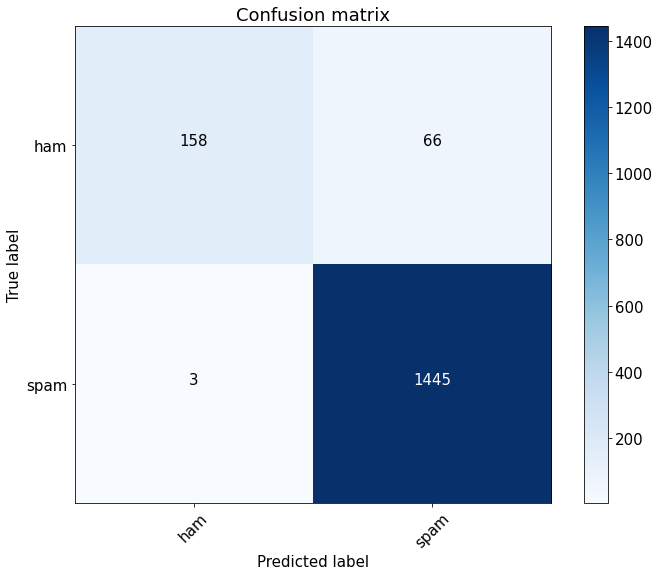

In [ ]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['ham', 'spam'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
my_result(cnf_matrix)

Модель логистической регрессии - результат работы: 
 Ошибки 1 рода (FP): 66, ошибки 2 рода (FN): 3 
точность модели (precision): 0.9563203176704169, полнота (recall): 0.9979281767955801


In [ ]:
data = df.copy()

In [ ]:
model_errors.join(data, how = 'left')

,Category_test,Category_predict,Category,Message
17,ham,spam,ham,Eh u remember how 2 spell his name... Yes i di...
40,spam,ham,ham,Pls go ahead with watts. I just wanted to be s...
47,spam,ham,ham,"Fair enough, anything going on?"
74,spam,ham,ham,U can call me now...
84,spam,ham,ham,Yup next stop.
...,...,...,...,...
1525,spam,ham,ham,Hi:)cts employee how are you?
1567,spam,ham,ham,I am late. I will be there at
1569,spam,ham,ham,Today is ACCEPT DAY..U Accept me as? Brother S...
1576,ham,spam,ham,"Sounds gd... Haha... Can... Wah, u yan jiu so ..."


## Что, если не делать предобработку исходных данных, а поручить все модели?

In [ ]:
# Попробуем поработать сразу на исходных данных
 
tfidf = TfidfVectorizer(strip_accents = 'unicode', lowercase = True, stop_words ={'english'}, ngram_range =(1,1))
tfidf_matrix = tfidf.fit_transform(data['Message'])
names = tfidf.get_feature_names_out() 
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, data_class, test_size=0.3, random_state=42) # разбиваем датаасет на обучающую и тестовую выборки
lr = LogisticRegression(solver = 'liblinear', penalty ='l1')

In [ ]:
lr.fit(X_train, y_train) # обучаем модель
y_pred = lr.predict(X_test) # прогнозируем класс
y_pred


array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
# смотрим разницу факта и прогноза
result = pd.DataFrame([y_test, y_pred]).T
result


,0,1
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1667,1,1
1668,0,0
1669,1,1
1670,0,0


In [ ]:
print('Количество сообщений с неправильно определенными классами: ', len(result[result[0]!=result[1]]))

Количество сообщений с неправильно определенными классами:  56


In [ ]:
# вероятность принадлежности к тому или иному классу
accuracy_score(y_test, y_pred)

0.9665071770334929

In [ ]:
lr.coef_ # коэффициенты модели

array([[0., 0., 0., ..., 0., 0., 0.]])

Во 2 случае вероятность принадлежности к классу даже выше!

Confusion matrix, without normalization
[[ 179   45]
 [  11 1437]]


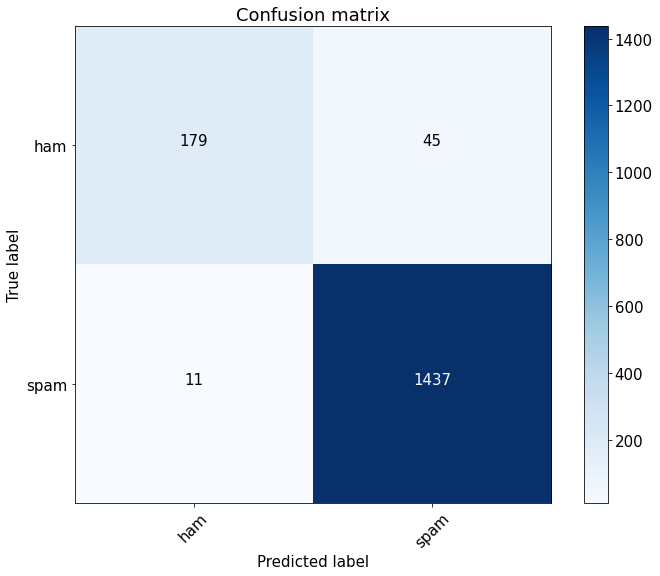

In [ ]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['ham', 'spam'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
my_result(cnf_matrix)

Модель логистической регрессии - результат работы: 
 Ошибки 1 рода (FP): 45, ошибки 2 рода (FN): 11 
точность модели (precision): 0.9696356275303644, полнота (recall): 0.9924033149171271
